In [287]:
import pandas as pd
import nltk
import seaborn as sn
import numpy as np
import cPickle as pickle
import re
import dateutil
import datetime
from collections import defaultdict
import got
import urllib2
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from cStringIO import StringIO
import os
import xml.etree.ElementTree as ET
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pylab as plot

params = {'legend.fontsize': 24,
          'legend.linewidth': 2}
plot.rcParams.update(params)

## hallooooooo

In [175]:
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")
stopwords = set(nltk.corpus.stopwords.words('dutch'))

def tokenize(inp):
    clean_inp = [stemmer.stem(x) for x in re.sub(r'(<al>|</al>|\shttp\w+\s|\s\w+\.\w+\s|\.|!|\?|,|:|\'|"|;)', "", inp)\
                 .lower().split() if re.match(r'^[a-zA-Z]+$', x) and x not in stopwords]
    return clean_inp

In [ ]:
# ref_text = nltk.FreqDist(tokenize(open('text', 'rb').read()))

In [249]:
parties = ['cdavandaag', 'christenunie', 'D66', 'groenlinks', 'PvdA', 'PartijvdDieren', 'SGPnieuws', 'SPnl', 'VVD',\
           '50plusfractie']
people = ['sybrandbuma', 'arieslob', 'APechtold', 'diederiksamsom', 'mariannethieme', 'geertwilderspvv',\
         'keesvdstaaij', 'emileroemer', 'MinPres', 'HenkKrol', 'bramvanojikgl']
for person in parties:
    print person
    tweetCriteria = got.manager.TweetCriteria().setUsername(person).setSince("2012-11-05").setUntil("2013-11-05")
    result = got.manager.TweetManager.getTweets(tweetCriteria)
    f = open('twitterdata/'+person+'.pkl', 'wb')
    pickle.dump(result, f)
    f.close()


cdavandaag
christenunie
D66
groenlinks
PvdA
PartijvdDieren
SGPnieuws
SPnl
VVD
50plusfractie


In [256]:
temp_tweet_dict = defaultdict(str)

for person in people+parties:
    print person
    f = open('twitterdata/'+person+'.pkl', 'rb')
    data = pickle.load(f)
    f.close()
    for tweet in data:
        temp_tweet_dict[person] += (tweet.text + " ")
temp_tweet_dict['PVV'] = ""
temp_tweet_dict['50plusfractie'] = ""
tweet_dict = {k: tokenize(v) for k, v in temp_tweet_dict.items()}
#totaltext = nltk.FreqDist(tokenize(" ".join(text_dict.values())))

sybrandbuma
arieslob
APechtold
diederiksamsom
mariannethieme
geertwilderspvv
keesvdstaaij
emileroemer
MinPres
HenkKrol
bramvanojikgl
cdavandaag
christenunie
D66
groenlinks
PvdA
PartijvdDieren
SGPnieuws
SPnl
VVD
50plusfractie


In [205]:
url_dict = {'sybrandbuma': 'https://d2vry01uvf8h31.cloudfront.net/CDA/Documenten/CDA_Verkiezingsprogram_2012-2017.pdf',\
            'arieslob': 'https://www.christenunie.nl/l/library/download/528106',\
            'APechtold': 'https://d66.nl/content/uploads/sites/2/2014/05/verkiezingsprogramma-d66-2012-2017.pdf',\
            'diederiksamsom': 'http://haarlem.productie.pvda.nl/wp-content/uploads/sites/96/2013/05/verkiezingsprogramma-2012.pdf',\
            'mariannethieme': 'https://www.partijvoordedieren.nl/downloads/www/2012/06/1340612862_PvdD_concept_verkiezingsprogramma_2012.pdf',\
            'geertwilderspvv': 'http://pubnpp.eldoc.ub.rug.nl/FILES/root/verkiezingsprogramma/TK/pvv2012/PVVTK2012.pdf',\
            'keesvdstaaij': 'http://static0.volkskrant.nl/static/asset/2012/269486_SGP_verkiezingsprogrammas_307.pdf',\
            'emileroemer': 'https://www.sp.nl/sites/default/files/sp-verkiezingsprogramma-nieuw-vertrouwen.pdf',\
            'MinPres': 'https://www.parlement.com/9291000/d/vvd2012.pdf',\
            'HenkKrol': 'https://www.50pluspartij.nl/images/PDFs/50plusVerkP_2013_14.pdf',\
            'bramvanojikgl': 'http://pubnpp.eldoc.ub.rug.nl/FILES/root/verkiezingsprogramma/TK/gl2012/GLTK2012prog.pdf'}

    
def download_file(url, filename):
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers={'User-Agent':user_agent,}
    req = urllib2.Request(url, headers=headers)
    response = urllib2.urlopen(req)
    file = open("partijplannen/"+filename, 'wb')
    file.write(response.read())
    file.close()

def extract_text_pdf(file_name):
    return_string = StringIO()  
    file_path = file("partijplannen/"+file_name, 'rb')
    
    device = TextConverter(PDFResourceManager(), return_string, codec='utf-8', laparams=LAParams())
    interpreter = PDFPageInterpreter(PDFResourceManager(), device)

    for page in PDFPage.get_pages(file_path):
        interpreter.process_page(page)
        
    file_path.close()

    text = return_string.getvalue()
    
    return_string.close()
    device.close()

    return text

In [ ]:
for name in url_dict:
    download_file(url, name+'.pdf')

In [209]:
partijplan_dict = {}
for name in url_dict:
    partijplan_dict[name] = tokenize(extract_text_pdf(name+'.pdf'))


In [210]:
lijsttrekkers = {'Van Haersma Buma': 'sybrandbuma', 'Slob': 'arieslob', 'Pechtold': 'APechtold',\
                 'Samsom': 'diederiksamsom', 'Thieme': 'mariannethieme', 'Wilders': 'geertwilderspvv',\
                 'Van der Staaij': 'keesvdstaaij', 'Rutte': 'MinPres', 'Roemer': 'emileroemer',\
                 'Krol': 'HenkKrol', 'Van Ojik': 'bramvanojikgl'}    
def create():
    total_text = defaultdict(str)
    kabinet_r2 = False
    for f in os.listdir('Wilders2014'):
        if f == 'h-tk-20122013-18-1.xml' :
            kabinet_r2 = True
        if kabinet_r2 == False:
            continue 
        tree = ET.parse("Wilders2014/" + f)
        root = tree.getroot()
        rol = {}
        for spreekbeurt in root.iter("spreekbeurt"):
            try:
                achternaam = spreekbeurt.find("spreker").find("naam").find("achternaam").text
                if achternaam == "Mark Rutte":
                    achternaam = "Rutte"
            except:
                continue
            if achternaam == "voorzitter" or spreekbeurt.find("spreker").text == "voorzitter":
                continue
            if achternaam in lijsttrekkers:
                for speech in spreekbeurt.iter("al"):
                        try:
                            total_text[lijsttrekkers[achternaam]] += " " + speech.text
                        except:
                            continue    
        if f == 'h-tk-20132014-19-21.xml':
            return total_text


total_text_dict = create()

In [211]:
debat_dict = {k: tokenize(v) for k, v in total_text_dict.items()}

In [271]:
people_party_dict = {'sybrandbuma': 'cdavandaag', 'arieslob': 'christenunie', 'APechtold': 'D66',\
                     'diederiksamsom': 'PvdA', 'mariannethieme': 'PartijvdDieren', 'geertwilderspvv': 'PVV',\
                     'keesvdstaaij': 'SGPnieuws', 'emileroemer': 'SPnl', 'MinPres': 'VVD',\
                     'HenkKrol': '50plusfractie', 'bramvanojikgl': 'groenlinks'}         
list_df = []

for name in people:
    vect = TfidfVectorizer(min_df=1)
    tfidf = vect.fit_transform([" ".join(partijplan_dict[name]), " ".join(debat_dict[name]),\
                                " ".join(tweet_dict[name]), " ".join(tweet_dict[people_party_dict[name]])])
    matr = (tfidf * tfidf.T).A
    list_df.append([name, matr[0,1], matr[0,2], matr[0,3]])

df = pd.DataFrame(list_df)
df.columns = ["Persoon", "Sim. partijprogramma-debat", "Sim. partijprogramma - pers. tweets",\
              "Sim. partijprogramma-partij tweets"]
df['Sim avg'] = df.apply(lambda x: ((x[1]+x[2]+x[3]) / float(3)) if x[3] != float(0) else ((x[1]+x[2]) / float(2)), axis=1)
df = df.sort_values('Sim avg', ascending=False)
df = df.set_index('Persoon')
df

,Sim. partijprogramma-debat,Sim. partijprogramma - pers. tweets,Sim. partijprogramma-partij tweets,Sim avg
Persoon,,,,
diederiksamsom,0.569890,0.590327,0.243997,0.468071
mariannethieme,0.465120,0.498196,0.388843,0.450720
geertwilderspvv,0.476492,0.373615,0.000000,0.425054
arieslob,0.476550,0.380725,0.390067,0.415781
HenkKrol,0.447722,0.341359,0.000000,0.394540
emileroemer,0.468704,0.333903,0.359565,0.387391
sybrandbuma,0.438221,0.282503,0.428992,0.383239
APechtold,0.490171,0.330008,0.293592,0.371257
bramvanojikgl,0.423092,0.275462,0.411446,0.370000


## halloooo again

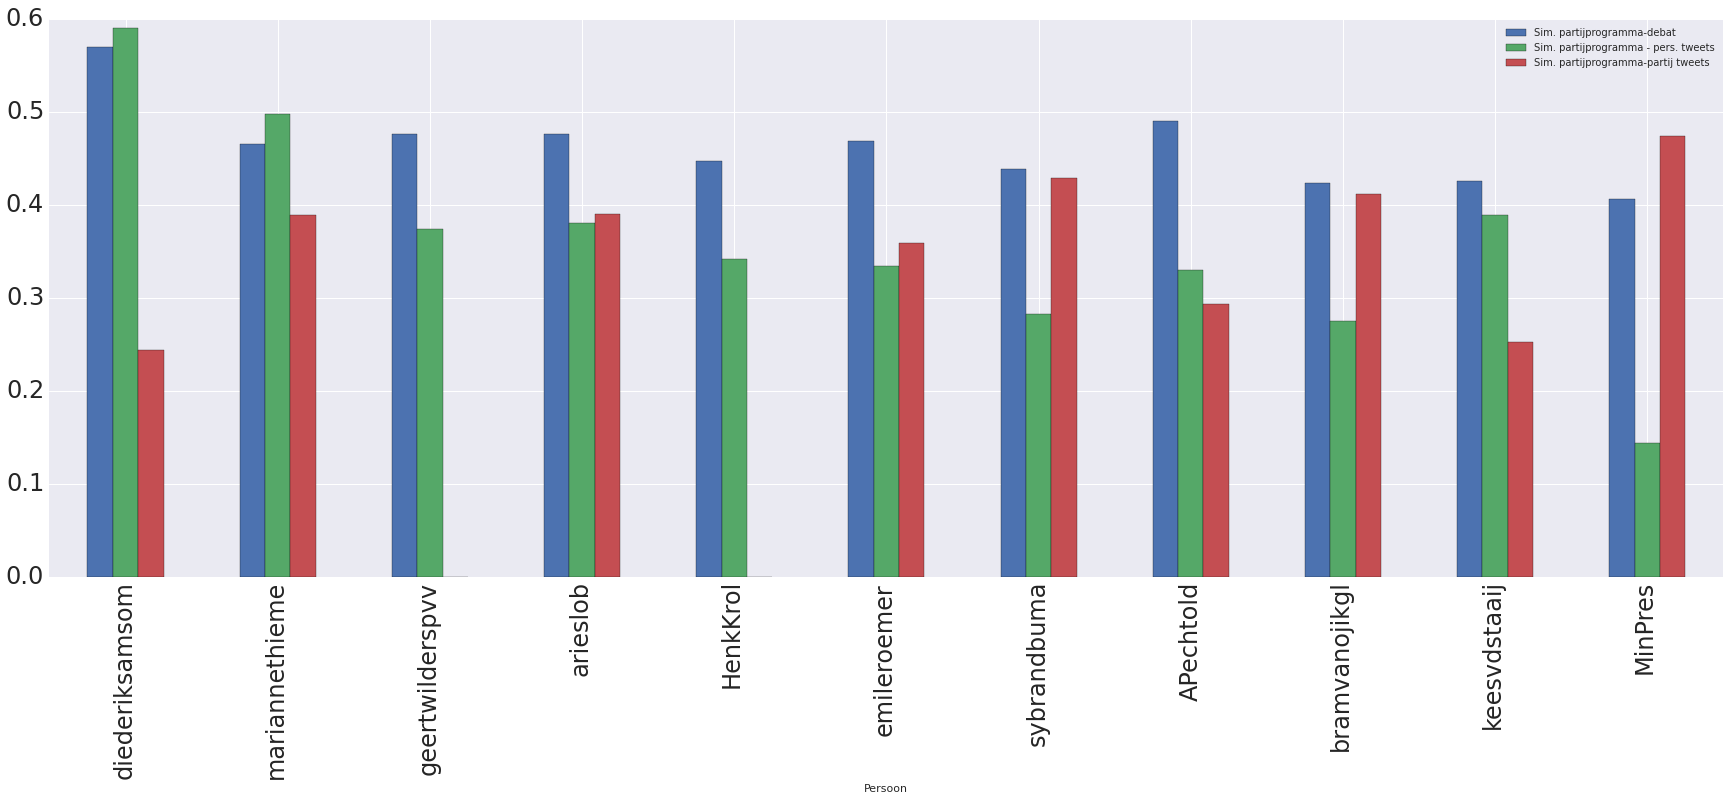

In [273]:
df[['Sim. partijprogramma-debat', 'Sim. partijprogramma - pers. tweets',\
    "Sim. partijprogramma-partij tweets"]].plot(kind='bar', figsize=(30,10), fontsize=24)

In [283]:
list_count_df = []
for person in people:
    list_count_df.append([person, len(partijplan_dict[person]), len(debat_dict[person]), len(tweet_dict[person]),\
                         len(tweet_dict[people_party_dict[person]])])
df_count = pd.DataFrame(list_count_df)
df_count.columns = ["Persoon", "Woorden in partijprogramma", "Woorden in debatten", "Woorden in persoonlijke tweets",\
                   "Woorden in partij-tweets"]
df_count = df_count.set_index('Persoon')
df_count['Totaal woorden'] = df_count.apply(lambda x: x[0]+x[1]+x[2]+x[3], axis=1)
df_count = df_count.sort_values("Totaal woorden", ascending=False)
df_count

,Woorden in partijprogramma,Woorden in debatten,Woorden in persoonlijke tweets,Woorden in partij-tweets,Totaal woorden
Persoon,,,,,
MinPres,12935,82767,2370,798,98870
diederiksamsom,21573,22281,23954,7168,74976
APechtold,14196,44129,6402,1190,65917
arieslob,22597,25931,9628,3029,61185
mariannethieme,9287,22843,20332,3719,56181
bramvanojikgl,12500,26912,698,7222,47332
keesvdstaaij,2388,39305,2502,452,44647
emileroemer,12341,18323,2889,5370,38923
sybrandbuma,9676,19500,4299,5366,38841


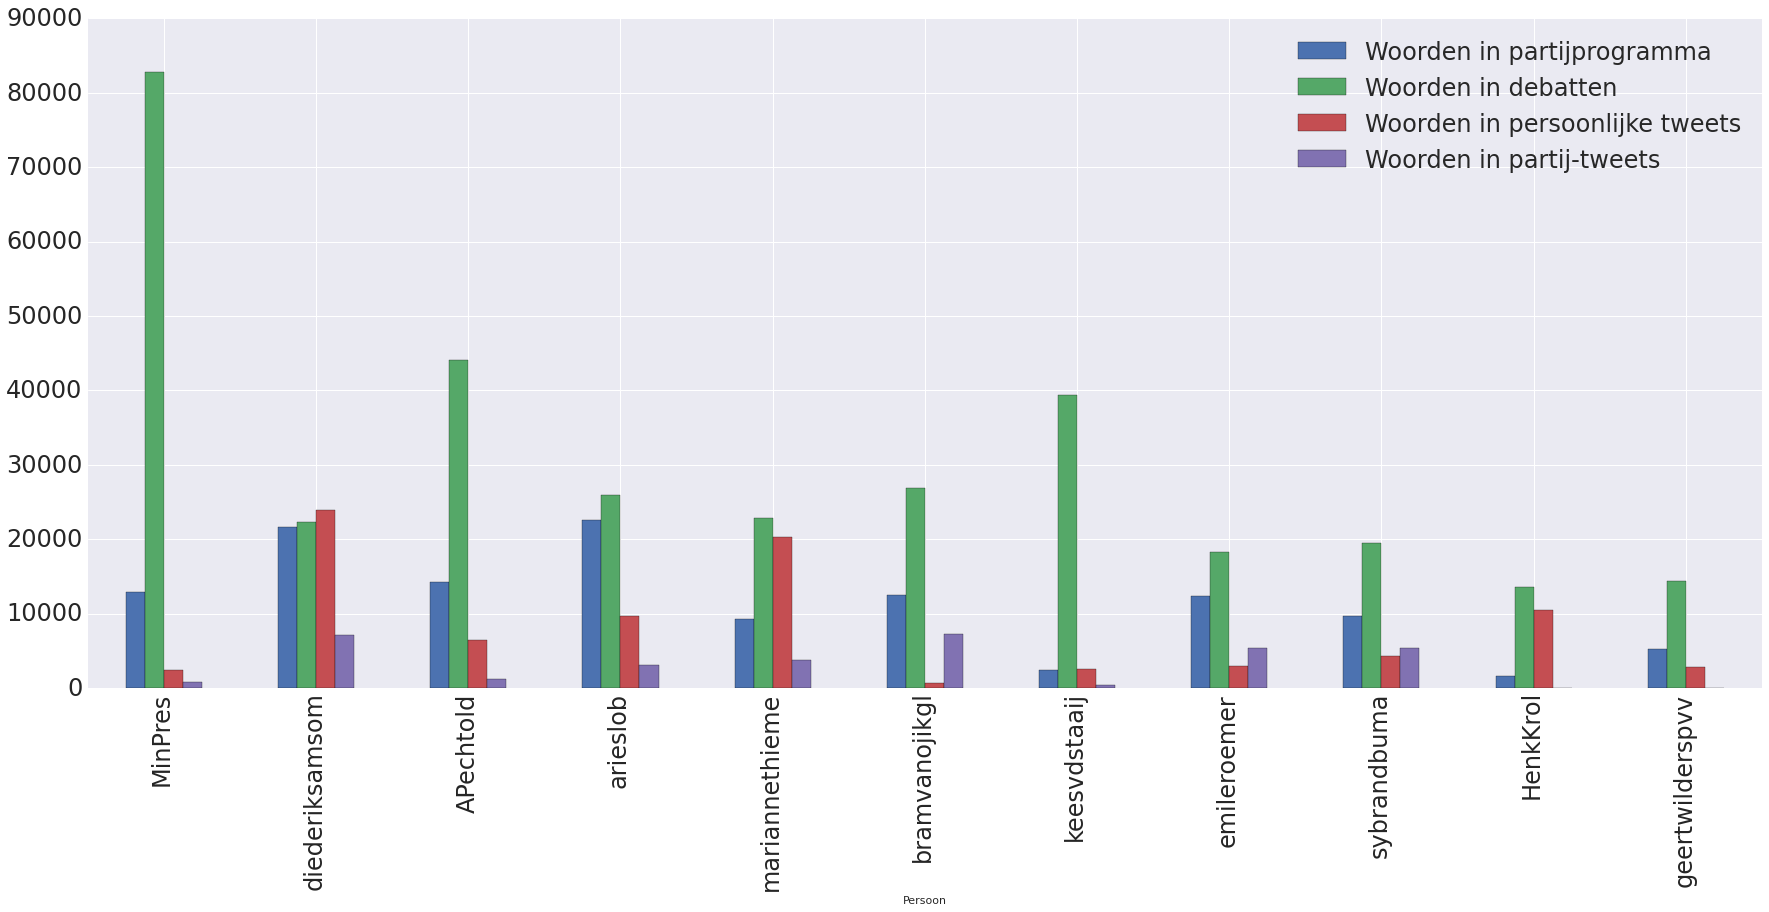

In [290]:
df_count.drop('Totaal woorden', axis=1).plot(kind='bar', figsize=(30,12), fontsize=24)

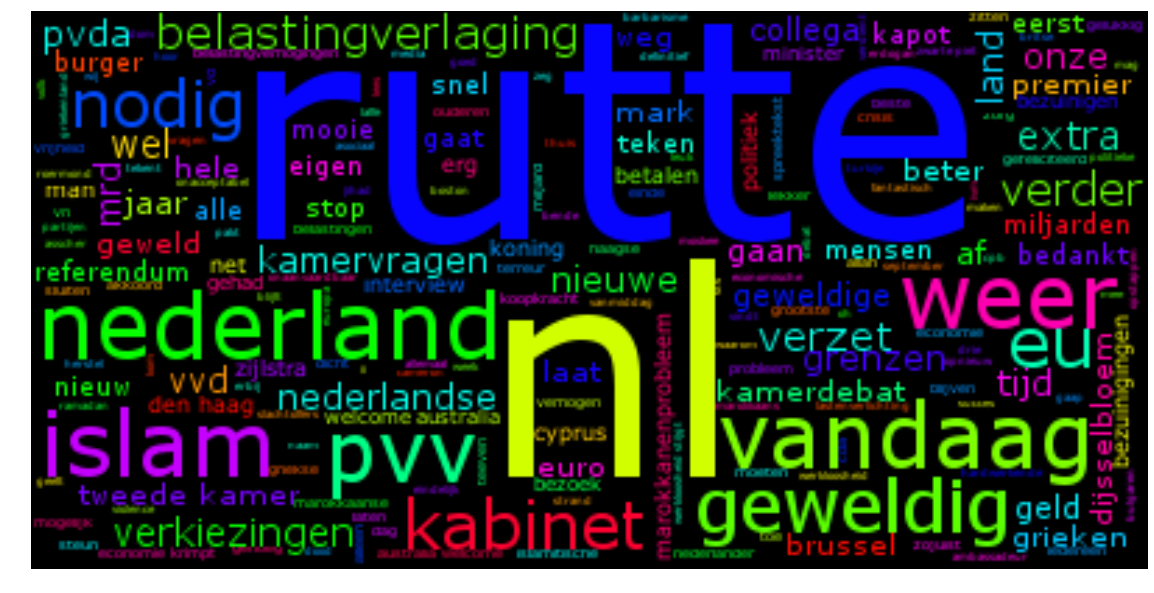

In [274]:
test = [x for x in re.sub(r'(<al>|</al>|\shttp\w+\s|\s\w+\.\w+\s|\.|!|\?|,|:|\'|"|;)', "", temp_tweet_dict['geertwilderspvv'])\
                 .lower().split() if re.match(r'^[a-zA-Z]+$', x) and x not in stopwords]
wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf').generate(" ".join(test))
# Open a plot of the generated image.
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
!ipython nbconvert --post serve --to slides --reveal-prefix "http://maartenmarx.nl/reveal.js" Final_project.ipynb

[NbConvertApp] Converting notebook Final_project.ipynb to slides
[NbConvertApp] Writing 1014927 bytes to Final_project.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdn.jsdelivr.net/reveal.js/2.6.2
Serving your slides at http://127.0.0.1:8000/Final_project.slides.html
Use Control-C to stop this server
